In [8]:
from autofit import conf
from autofit.core import non_linear
from autofit.core import model_mapper
from autolens.pipeline import phase as ph
from autolens.model.galaxy import galaxy_model as gm
from autolens.imaging import image as im
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.imaging.plotters import imaging_plotters
from autolens.lensing.plotters import lensing_fitting_plotters

# In the previous example, we used a non-linear search to infer the best-fit lens model to a strong lens image. In this 
# example, we'll get a deeper intuition of how a non-linear search works.

# First, I want to develop the idea of a 'parameter space'. Lets think of a function, like the simple function below:

# f(x) = x^2

# In this function, when we input a parameter x, it returns a value f(x). The mappings between different values of x 
# and f(x) define a parameter space (and if you remember your high school math classes, you'll remember this parameter 
# space can be drawn as a parabola!)

# A function can of course have multiple parameters:

# f(x, y, z) = x + y^2 - z^3

# This function has 3 parameters, x, y and z. The mappings between x, y and z and f(x, y, z) again define a parameter
# space, albeit it now 3 dimensions. Nevertheless, one could still picture this parameter space as some 3 dimensional 
# curved surface).

# The process of computing a likelihood in AutoLens can be visualized in exactly the same way. We have a set of lens 
# model parameters, which we input into AutoLens's 'likelihood function'. Now, this likelihood function isn't something
# that we can write down analytically, and its going to be inherently non-linear. But, nevertheless, it is a function,
# if we put the same set of lens model parameters into it, we'll compute the same likelihood. 

# We can write our likelihood function as follows (using x_mp, y_mp, I_lp etc. as short-hand notation for the 
# mass-profile and light-profile parameters):

# f(x_mp, y_mp, R_mp, x_lp, y_lp, I_lp, R_lp) = a likelihood from AutoLens's tracer / fitting modules

# The point is, like we did for the simple functions above, we again have a parameter space! It can't be written down 
# analytically and its undoubtedly very complex and non-linear. Fortunately, we've already learnt how to search it, and
# find the solutions which maximize our likelihood function!

# Lets inspect the results of the last tutorial's non-linear search. We're going to look at what are called 'probably
# density functions', or PDF's for short. These represent where the highest likelihood regions of parameter space
# were found for each parameter.
#
# Navigate to the folder 'AutoLens/output/howtolens/1_non_linear_search/optimizer/pdfs' and open the 'Triangle.pdf'
# figure. This Gaussian shaped lines running down the diagonal of this triangle represent 1D estimates of the highest 
# likelihood regions that were found in parameter space for each parameter. 
 
# The remaning figures, which look like contour-maps, show the maximum likelihood regions in 2D between every parameter 
# pair. We often see that two parameters are 'degenerate', whereby increasing one and decreasing the other leads to a 
# similar likelihood value. The 2D PDF between the source galaxy's light-profile's intensity (I_l4) and effective 
# radius (R_l4) shows a degeneracy. This makes sense - making the source galaxy brighter and smaller is similar to
# making it fainter and bigger!

# So, how does PyAutoLens know where to look in parameter space? A parameter, say, the Einstein Radius, could in 
# principle take any value between negative and positive infinity. AutoLens must of told it to only search regions of 
# parameter space with 'reasonable' values (i.e. Einstein radii of around 1"-3").

# These are our 'priors' - they are where we tell the non-linear search to search parameter space. PyAutoLens uses two 
# types of prior:

# 1) UniformPrior - The values of a parameter are randomly drawn between a lower and upper limit. For example, the
#                   orientation angle phi of a profile typically assumes a uniform prior between 0.0 and 180.0 degrees.

# 2) GaussianPrior - The values of the a parameter are randomly drawn from a Gaussian distribution with a mean value
#                    and a width sigma. For example, an Einstein radius might assume a mean value of 1.0" and width
#                    of sigma = 1.0".
#

# The default priors on all parameters can be found by navigating to the 'config/priors/default' folder, and inspecting
# config files like light_profiles.ini. The convention is as follow:

# [EllipticalSersic]          # These are the priors used for an EllipticalSersic profile.
# intensity=u,0.0,1.0         # Its intensity uses a UniformPrior with lower_limit=0.0, upper_limit=1.0
# effective_radius=u,0.0,2.0  # Its effective radius uses a UniformPrior with lower_limit=0.0, upper_limit=2.0
# sersic_index=g,4.0,2.0      # Its Sersic index uses a GaussianPrior with mean=4.0 and sigma=2.0

In [ ]:
# Lets again setup the paths and config-overrides for this chapter, so the non-linear search runs fast. 

# If you are using Docker, the paths to the chapter is as follows (e.g. comment out this line)!
# path = '/home/user/workspace/howtolens/chapter_2_lens_modeling'

# If you arn't using docker, you need to change the path below to the chapter 2 directory and uncomment it
# path = '/path/to/user/workspace/howtolens/chapter_2_lens_modeling'
conf.instance = conf.Config(config_path=path+'/configs/2_parameter_space_and_priors', output_path=path+"/output")

In [11]:
# This function simulates the image we'll fit in this tutorial - which is identical to the previous tutorial.
def simulate():

    from autolens.imaging import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lensing import ray_tracing

    psf = im.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.1, pixel_scale=0.1)

    image_plane_grids = grids.ImagingGrids.grids_for_simulation(shape=(130, 130), pixel_scale=0.1, psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(mass=mp.SphericalIsothermal(centre=(0.0, 0.0), einstein_radius=1.6))
    source_galaxy = g.Galaxy(light=lp.SphericalExponential(centre=(0.0, 0.0), intensity=0.2, effective_radius=0.2))
    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                                 image_plane_grids=[image_plane_grids])

    image_simulated = im.Image.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.1,
                                           exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

    return image_simulated

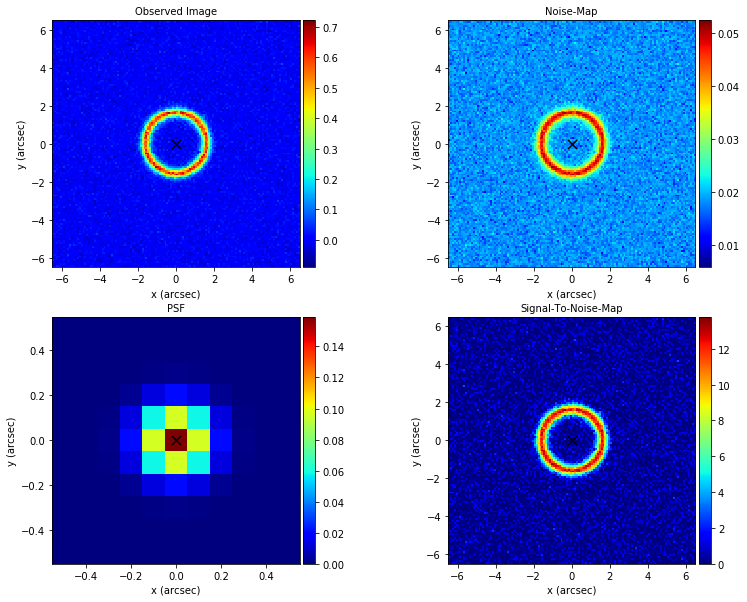

In [12]:
# Again, lets setup the simulated image
image = simulate()
imaging_plotters.plot_image_subplot(image=image)


In [13]:
#  To change the priors on specific parameters, we create our galaxy model's and then use a custom-phase and its
# 'pass_priors' function to overwrite priors on specific parameters.

lens_galaxy_model = gm.GalaxyModel(mass=mp.SphericalIsothermal)
source_galaxy_model = gm.GalaxyModel(light=lp.SphericalExponential)

class CustomPhase(ph.LensSourcePlanePhase):

    def pass_priors(self, previous_results):

        # To change priors, we use the 'model_mapper' module. This is what links our GalaxyModel's to the non-linear
        # search. Thus, it tells PyAutoLens where to search non-linear parameter space.

        # These two lines change the centre of the lens galaxy's mass-profile to UniformPriors around the coordinates
        # (-0.1", 0.1"). For real lens modeling, this might be done by visually inspecting the centre of emission of
        # the lens galaxy's light.

        # The term 'lens_galaxy' refers to the name of the galaxy that we give it below (scroll down cell [5]. 
        # By naming galaxies in this way, we can easily keep track of how to pass their priors).

        # The word 'mass' corresponds to the word we used when setting up the GalaxyModel above.

        self.lens_galaxies.lens_galaxy.mass.centre_0 = model_mapper.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
        self.lens_galaxies.lens_galaxy.mass.centre_1 = model_mapper.UniformPrior(lower_limit=-0.1, upper_limit=0.1)

        # Lets also change the prior on the lens galaxy's einstein radius, to a GaussianPrior centred on 1.4".
        # For real lens modeling, this might be done by visually estimating the radius the lens's arcs / ring appear.

        self.lens_galaxies.lens_galaxy.mass.einstein_radius = model_mapper.GaussianPrior(mean=1.4, sigma=0.2)

        # We can also customize the source galaxy - lets say we believe it is compact and limit its effective radius

        self.source_galaxies.source_galaxy.light.effective_radius = \
            model_mapper.UniformPrior(lower_limit=0.0, upper_limit=0.3)

MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/2_custom_priorsfolder for live output of the results, images and lens model.This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!


/home/jammy/PyCharm/Projects/AutoLens/workspace/howtolens/chapter_2_lens_modeling/output/2_custom_priors/optimizer/multinest.txt
Removed no burn in


Analysis Result:
constant: <autofit.core.model_mapper.ModelInstance object at 0x7fc35b7f46a0>
likelihood: 6610.593735684564
variable: <autofit.core.model_mapper.ModelMapper object at 0x7fc35b57e128>
fit: <autolens.lensing.lensing_fitting.LensingProfileFit object at 0x7fc362d8ddd8>


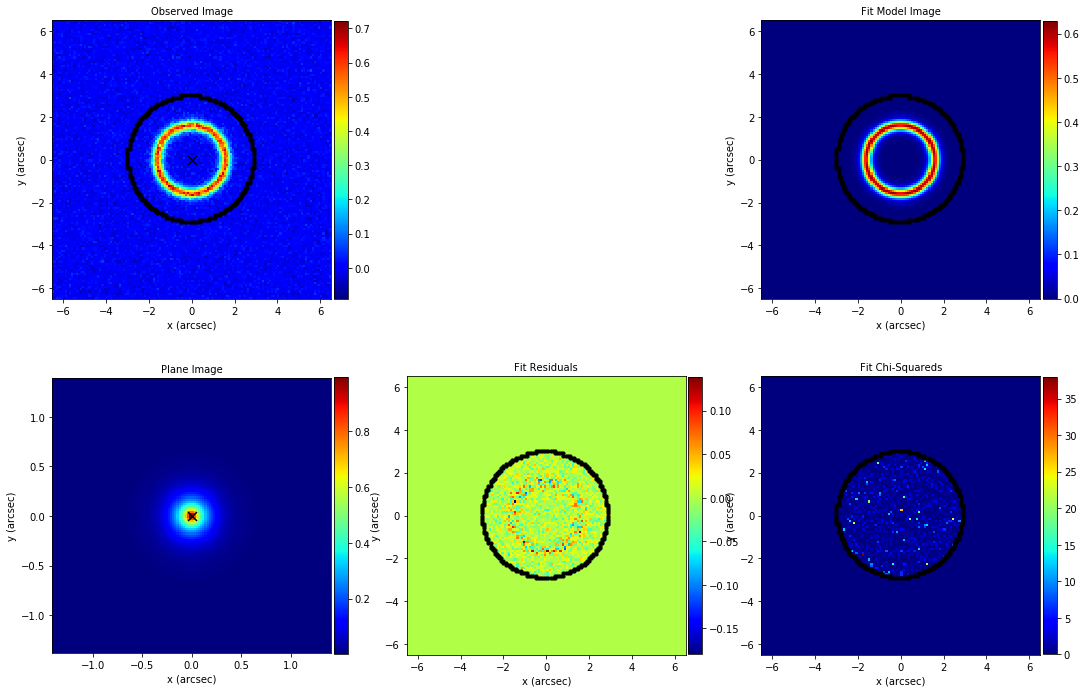

In [14]:
# (If the use of a python 'class' here, or some of the python code doesn't appear clear, don't worry about it. This
# code is using a number of Python's object-oriented features. In general, I expect that'll you'll simply copy the code
# above and use it as a template).

# We can now create this custom phase like we did a normal phase before. When we run the phase, the pass_prior function
# will be called automatically and thus change the priors as we specified above. If you look at the 'model.info'
# file in the output of the non-linear search, you'll see that the priors have indeed been changed.
custom_phase = CustomPhase(lens_galaxies=dict(lens_galaxy=lens_galaxy_model), 
                           source_galaxies=dict(source_galaxy=source_galaxy_model),
                           optimizer_class=non_linear.MultiNest,
                           phase_name='2_custom_priors')

print('MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/2_custom_priors'
      'folder for live output of the results, images and lens model.'
      'This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!')
results_custom = custom_phase.run(image)
print(results_custom) # NOTE - this isn't working yet, need to sort out.
lensing_fitting_plotters.plot_fitting_subplot(fit=results_custom.fit)
print('MultiNest has finished run - you may now continue the notebook.')

In [ ]:
# And, we're done. This tutorial had some pretty difficult concepts to wrap your head around. However, I can't 
# emphasize enough how important it is that you develop an intuition for non-linear searches and the notion of a
# non-linear parameter space. Becoming good at lens modeling is all being able to navigate a complex, degenerate and
# highly non-linear parameter space! Luckily, we're going to keep thinking about this in the next set of exercises, 
# so if you're not feeling too confident yet, you should be in a few exercises time!

# Before continuing to the next tutorial, I want you think about whether anything could go wrong when we search a 
# non-linear parameter space. Is it possible that we won't find the highest likelihood lens model? Why might this be? 
# 
# Try and list 3 reasons why this might happen. In the next tutorial, we'll learn about just that - failure!